# Introduction

In this project we will be analyzing the Northwind database to generate hypothesis and test them using statistical and stocastic methods. 


## Import Libraries and Connect to Database

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sqlite3
from statsmodels.stats.multicomp import MultiComparison 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from khantools import *

conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

q7= """
    SELECT 
        
        P.ProductName,
        OD.Quantity,
        OD.UnitPrice,
        OD.Discount AS DiscRate,
        OD.Id as ODRecords,
        (OD.UnitPrice * OD.Quantity) * (OD.Discount) AS DiscAmount,
        (OD.UnitPrice * OD.Quantity) * (1 - OD.Discount) AS TotalPaid,
        E.Firstname || ' ' || E.LastName AS EmpName,
        E.Region AS EmpRegion,
        C.Region AS CustRegion,
        S.Region AS SuppRegion
        
        
    FROM OrderDetail as OD
    JOIN `Order` AS O ON OD.OrderID = O.Id 
    JOIN Product as P ON OD.ProductId = P.Id
    JOIN Employee AS E on E.Id = O.EmployeeId
    JOIN Customer AS C on C.Id = O.CustomerId
    JOIN Supplier AS S on P.SupplierId = S.Id
  
    
    
    ORDER BY EmployeeId ASC
    
    
"""

cursor = cur.execute(q7)
names = [description[0] for description in cursor.description]
df_master = pd.DataFrame(cursor.fetchall(),columns=names)
display(df_master)


,ProductName,Quantity,UnitPrice,DiscRate,ODRecords,DiscAmount,TotalPaid,EmpName,EmpRegion,CustRegion,SuppRegion
0,Chang,50,15.2,0.2,10258/2,152.00,608.00,Nancy Davolio,North America,Western Europe,British Isles
1,Chef Anton's Gumbo Mix,65,17.0,0.2,10258/5,221.00,884.00,Nancy Davolio,North America,Western Europe,North America
2,Mascarpone Fabioli,6,25.6,0.2,10258/32,30.72,122.88,Nancy Davolio,North America,Western Europe,Southern Europe
3,Inlagd Sill,30,15.2,0.0,10270/36,0.00,456.00,Nancy Davolio,North America,Scandinavia,Northern Europe
4,Ipoh Coffee,25,36.8,0.0,10270/43,0.00,920.00,Nancy Davolio,North America,Scandinavia,South-East Asia
...,...,...,...,...,...,...,...,...,...,...,...
2073,Teatime Chocolate Biscuits,35,9.2,0.0,11022/19,0.00,322.00,Anne Dodsworth,British Isles,South America,British Isles
2074,Gudbrandsdalsost,30,36.0,0.0,11022/69,0.00,1080.00,Anne Dodsworth,British Isles,South America,Scandinavia
2075,Sir Rodney's Scones,3,10.0,0.0,11058/21,0.00,30.00,Anne Dodsworth,British Isles,Western Europe,British Isles
2076,Camembert Pierrot,21,34.0,0.0,11058/60,0.00,714.00,Anne Dodsworth,British Isles,Western Europe,Western Europe


<img src='Northwind_ERD_updated.png'>

## Statistical Testing Functions 

Lets write out some functions to make it easier to test our hypotheses down the line.

In [2]:
def Cohen_d(control, experiment):
   
    diff = experiment.mean() - control.mean()

    n1, n2 = len(experiment), len(control)
    var1 = experiment.var()
    var2 = control.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [3]:
def monte_carlo(a,b,size):
    """  Runs a monte carlo simulations on two pandas series (a and b)  """
    

    diff_mu_a_b = np.mean(b) - np.mean(a)
    num = 0
    denom = 0
    union = a.append(b,ignore_index=True)
       
    
    for i in range(size):
       
        
        ai = union.sample(len(a))
        
        
        bi = union.drop(ai.index)
                 
        diff_mu_ai_bi = np.mean(bi) - np.mean(ai)
        
        if diff_mu_ai_bi >= diff_mu_a_b:
            num +=1
            
        denom += 1
        
    p_val = num/denom
    print("In {} samples, The difference in mean between the experimental group and control group was higher than the observed values {} % percent of the time".format(size,p_val*100))
    return p_val
    
      

In [4]:

def hyp_test_mean(control,experiment):
    
    """ Tests the null hypothesis that an experimental sample comes from the same population as a control sample
        Runs a students t-test, a Welch's t-test and a Mann Whitney test, and then indicated which results are most reliable
        based on whether the assumptions for each respective test have been met or not. 

        Samples must be passed in as pandas series. 
    """
    
# 1. Test variances
    w,p_same_var = stats.levene(control,experiment)
# 2. Test nromality
    w,p_norm_a = stats.normaltest(control)
    w,p_norm_b = stats.normaltest(experiment)
    
# 3. Run tests
    
    t_test_result = stats.ttest_ind(control,experiment)[1]
    welch_result = stats.ttest_ind(control,experiment,equal_var=False)[1]
    mann_whitney_u = stats.mannwhitneyu(control,experiment)[1]
    
# 4. Choose best test

    norm_pass = ((p_norm_a >= 0.05) and (p_norm_b >= 0.05)) or ( (len(control) > 30) and (len(experiment) > 30) )
    var_pass = p_same_var >= 0.05
    
    if var_pass and norm_pass:
        t_test_notes = "1 !!Best Test!!"
        welch_notes = "not used; t-test assumptions met"
        mann_whitney_u_notes = "not needed; t-test assumptions met"
    elif norm_pass and not var_pass:
        welch_notes = "1 !!Best Test!!"
        t_test_notes = "not used: assumptions not met"
        mann_whitney_u_notes = "not needed: Welch's assumptions met"
    else:
        welch_notes = "not used: assumptions not met"
        t_test_notes = "not used: assumptions not met"
        mann_whitney_u_notes = "1 !!Best Test!!"

# 5. results in df
    test_name = ['t_test','Welch\'s t-test','Mann Whitney U']
    df_dict={
        'Difference in means': [0,(np.mean(experiment) - np.mean(control))],
        'Cohen\'s d': [0,Cohen_d(control,experiment)],
        'Sample A normality':[p_norm_a,'0'],
        'Samp B normality':[p_norm_b,'0'],
        'Variance similarity': [p_same_var,'0'],
        't_test':[t_test_result,t_test_notes],
        'Welch\'s t-test' :[welch_result,welch_notes],
        'Mann Whitney U':[mann_whitney_u,mann_whitney_u_notes]
        
    }
    
    df = pd.DataFrame.from_dict(df_dict,orient = 'index',columns=['p_value','notes'])
    df['Null Rejected'] = (df['p_value'] < 0.05)
    df['p_value'].round(4)
    display(df)
    return df

# First Hypothesis: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

<b>Null Hypthesis:</b>
Discounts do not cause people to purchase greater quantities of products

<b>Alternative Hypothesis:</b>People order a product in greater quantities if they are offered a discount

Lets load the relevant data. 

In [5]:
# ______________Dataframe with Quantity and Discount data on all orders_______________

q1= """
    SELECT Quantity,Discount 
    FROM OrderDetail 
    GROUP BY `Id`
"""

cursor = cur.execute(q1)
names = [description[0] for description in cursor.description]

df_all_orders = pd.DataFrame(cursor.fetchall(),columns=names)


# ______________Control Dataframe; Only has data just for orders where no discounts were applied______________

q2= """
    SELECT Quantity,Discount
    FROM OrderDetail 
    WHERE Discount = 0 
    GROUP BY `Id` 
"""

cursor = cur.execute(q2)
names = [description[0] for description in cursor.description]

df_no_discounts = pd.DataFrame(cursor.fetchall(),columns=names)


# ______________Experimental Dataframe; Only has data just for orders where no discounts were applied______________


q3= """
    SELECT Quantity,Discount
    FROM OrderDetail 
    WHERE Discount != 0 
    GROUP BY `Id` 
"""

cursor = cur.execute(q3)
names = [description[0] for description in cursor.description]

df_with_discounts = pd.DataFrame(cursor.fetchall(),columns=names)


## Testing the Null Hypothesis

Let us test the null hypothesis that the average quantity ordered is the same for orders with discounts applied as it is for orders with no discounts applied using the hypothesis testing pipeline function we defined above. 

This pipeline will check the sample sizes, whether the two samples are normally distributed and whether they have equal variance. It will then run a student's t-test, a Welch's t test andr a Mann Whitney U test on both samples, and tell us in the notes which test is most reliable based on whether or not the normality and variance assumptions have been met


In [6]:
df2 = hyp_test_mean(df_no_discounts['Quantity'],df_with_discounts['Quantity'])
display(df2)

,p_value,notes,Null Rejected
Difference in means,0.000000e+00,5.39452,True
Cohen's d,0.000000e+00,0.286272,True
Sample A normality,5.579637e-119,0,True
Samp B normality,1.621488e-57,0,True
Variance similarity,1.209138e-04,0,True
t_test,1.144092e-10,not used: assumptions not met,True
Welch's t-test,5.656414e-10,1 !!Best Test!!,True
Mann Whitney U,6.629382e-11,not needed: Welch's assumptions met,True


,p_value,notes,Null Rejected
Difference in means,0.000000e+00,5.39452,True
Cohen's d,0.000000e+00,0.286272,True
Sample A normality,5.579637e-119,0,True
Samp B normality,1.621488e-57,0,True
Variance similarity,1.209138e-04,0,True
t_test,1.144092e-10,not used: assumptions not met,True
Welch's t-test,5.656414e-10,1 !!Best Test!!,True
Mann Whitney U,6.629382e-11,not needed: Welch's assumptions met,True


It seems that we the null hypothesis has been rejected by all tests, including the Welch's test which is indicated as being the best one given the status of normality and variance of the samples.

Lets run a Monte Carlo simualtion to double check the results. 

In [7]:
p = monte_carlo(df_no_discounts['Quantity'],df_with_discounts['Quantity'],10000)

print(p)

In 10000 samples, The difference in mean between the experimental group and control group was higher than the observed values 0.0 % percent of the time
0.0


OUr Monte Carlo simulation seems to confirm what our Welch's t-test. In 10,000 samples we did not find even one where the mean of a randomly sampled group of the same size as the experimental group was higher than the mean of the control group.

## Conclusion

It seems that there is a statistically significant increase in quantity ordered if a discount is being applied to the item in the order. The size of this increase for all levels of discount can be seen by the Cohen's d of 0.286 which is a small to moderate effect on the quantity ordered. 

Lets move to the second part of the question and take a closer look at effect sizes.

## Effect sizes at different levels of discount

Lets start of by running a pairwise Tukey's test on the discount levels to quickly get a sense of what the effect size is at different levels of discounts

In [8]:
mc = MultiComparison(df_all_orders['Quantity'],df_all_orders['Discount'])
result = mc.tukeyhsd()

print(result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   0.0   0.01 -19.7153    0.9 -80.3306 40.9001  False
   0.0   0.02 -19.7153    0.9  -62.593 23.1625  False
   0.0   0.03 -20.0486  0.725 -55.0714 14.9742  False
   0.0   0.04 -20.7153    0.9 -81.3306 39.9001  False
   0.0   0.05   6.2955 0.0011   1.5381  11.053   True
   0.0   0.06 -19.7153    0.9 -80.3306 40.9001  False
   0.0    0.1   3.5217 0.4269  -1.3783  8.4217  False
   0.0   0.15   6.6669 0.0014    1.551 11.7828   True
   0.0    0.2   5.3096 0.0303   0.2508 10.3684   True
   0.0   0.25    6.525 0.0023   1.3647 11.6852   True
  0.01   0.02      0.0    0.9 -74.2101 74.2101  False
  0.01   0.03  -0.3333    0.9 -70.2993 69.6326  False
  0.01   0.04     -1.0    0.9 -86.6905 84.6905  False
  0.01   0.05  26.0108    0.9  -34.745 86.7667  False
  0.01   0.06      0.0    0.9 -85.6905 85.6905  False
  0.01    0.1   23.237    0.

Interesting: it seems there is a statistically significant difference in means at most of the discount levels. However, this resul oject is a little hard to interpret and has data on comparisons between discount levels, which is not pertinent to our inquiry. 

Lets manually examine the discount levels and their attendant effect sizes

In [9]:
discount_levels = df_with_discounts['Discount'].value_counts()
display(discount_levels)

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.06      1
0.01      1
0.04      1
Name: Discount, dtype: int64

It seems there are some discount percentages that are rarely applied. They will most likely just add noise to our analysis and it might be best to dispense with them. Lets also convert the relevant discount sizes into a list we can iterate through later

In [10]:
discount_list = list(discount_levels[discount_levels > 10].index)
display(discount_list)

[0.05, 0.1, 0.2, 0.15, 0.25]

Now lets calculate the average quantity and Cohen's d at each relevant discount level. 
The code below will return a data frame with the mean quantity ordered, the difference from the null mean and the Cohen's for each level of discount. We will then plot the Cohen's d to assess the effect of each discount level on the quantity ordered. 

,Mean,Mean Difference,Cohen's D
0.05,28.010811,6.295549,0.346877
0.10,25.236994,3.521732,0.195942
0.20,27.024845,5.309583,0.300712
0.15,28.382166,6.666904,0.372404
0.25,28.240260,6.524998,0.366593


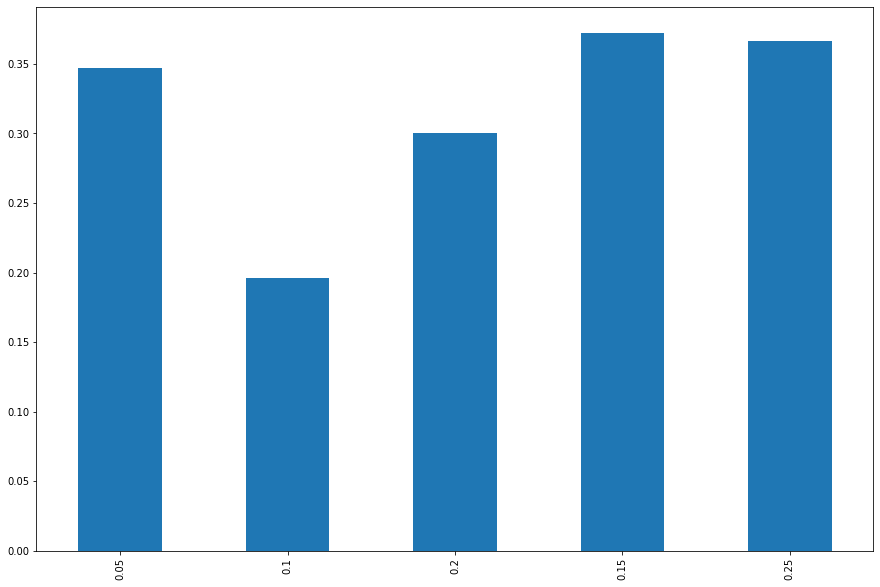

In [11]:
df_dict = {}

for i in discount_list:
    disc_df = df_with_discounts[df_with_discounts['Discount'] == i]['Quantity']
    cohen_d= Cohen_d(df_no_discounts['Quantity'],disc_df)
    mean = disc_df.mean()
    mean_diff = disc_df.mean() - df_no_discounts['Quantity'].mean()
    df_dict[i] = [mean, mean_diff,cohen_d]

effects_df = pd.DataFrame.from_dict(df_dict,orient='index',columns=['Mean','Mean Difference','Cohen\'s D'])
display(effects_df)   

effects_df['Cohen\'s D'].plot(kind='bar',figsize=(15,10))
fig = plt.gcf()
fig.savefig("DiscountEffectSize")
plt.show()


## Conclusion

It seems that discounts of 5,20, 15 and 25 percent have the most effect on quantity ordered. What is interesting is that a 10% discount seems to have less of an effect on the quantity ordered. Perhaps its worth exploring the data further to see when a 10 percent discount is applied and what about those situations might lead to a reduced effect on quantity ordered. However, based just off the data we have before us, it might make sense to phase out the 10% discount altogether or reduce it to 5%. By doing so, we will offer less of a discount and thus lose less revenue since a 10% discount is not having much of an effect on increasing sales. 

# Second Hypothesis: Does discount level lead to higher revenue?

<b> Null Hypothesis:</b> The revenue generated by discounted orders is the same as the revenue from ordes where not discount was applied. 

<b> Alt Hypothesis:</b> Discounted orders generate more revenue. 
    


,Discount,TotalPaid
0,0.05,15019.50
1,0.20,8432.00
2,0.20,8263.36
3,0.05,7509.75
4,0.25,6324.00
...,...,...
833,0.20,16.00
834,0.20,14.40
835,0.25,14.40
836,0.10,8.64


The average revenue per order from discounted orders is $614.67


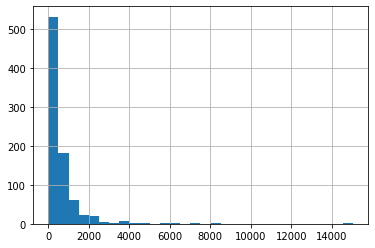

In [12]:
q4= """
    SELECT       
        Discount,          
        ((OrderDetail.UnitPrice * Quantity) * (1 - Discount)) AS TotalPaid
    FROM OrderDetail 
    JOIN Product ON OrderDetail.ProductId = Product.Id
    WHERE Discount !=0
    ORDER BY TotalPaid DESC
    
    
"""

cursor = cur.execute(q4)
names = [description[0] for description in cursor.description]
df_totals_disc = pd.DataFrame(cursor.fetchall(),columns=names)
display(df_totals_disc)
df_totals_disc['TotalPaid'].hist(bins = 30)

avg_paid_disc = round(df_totals_disc['TotalPaid'].mean(),2)
print("The average revenue per order from discounted orders is ${}".format(avg_paid_disc))

,Discount,TotalPaid
0,0.0,15810.0
1,0.0,10540.0
2,0.0,10540.0
3,0.0,9903.2
4,0.0,7905.0
...,...,...
1312,0.0,14.0
1313,0.0,13.5
1314,0.0,12.5
1315,0.0,7.3


The average revenue per order from regularly priced orders is $570.01


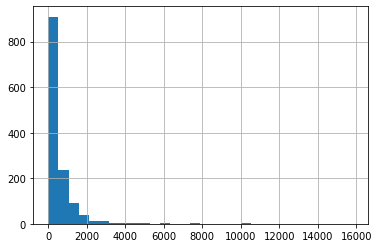

In [13]:
q5= """
    SELECT       
        Discount,          
        ((OrderDetail.UnitPrice * Quantity) * (1 - Discount)) AS TotalPaid
    FROM OrderDetail 
    JOIN Product ON OrderDetail.ProductId = Product.Id
    WHERE Discount = 0
    ORDER BY TotalPaid DESC
    
    
"""

cursor = cur.execute(q5)
names = [description[0] for description in cursor.description]
df_totals_no_disc = pd.DataFrame(cursor.fetchall(),columns=names)
display(df_totals_no_disc)
df_totals_no_disc['TotalPaid'].hist(bins = 30)
avg_paid_no_disc = round(df_totals_no_disc['TotalPaid'].mean(),2)
print("The average revenue per order from regularly priced orders is ${}".format(avg_paid_no_disc))

## Testing the Null

In [14]:
pd.set_option('display.float_format', lambda x:'%.6f' % x)
control2 = df_totals_no_disc['TotalPaid']
experiment2 = df_totals_disc['TotalPaid']

hyp2 = hyp_test_mean(control2,experiment2)
display(hyp2)


,p_value,notes,Null Rejected
Difference in means,0.000000,44.664619,True
Cohen's d,0.000000,0.046084,True
Sample A normality,0.000000,0,True
Samp B normality,0.000000,0,True
Variance similarity,0.476733,0,False
t_test,0.297115,1 !!Best Test!!,False
Welch's t-test,0.299355,not used; t-test assumptions met,False
Mann Whitney U,0.032567,not needed; t-test assumptions met,True


,p_value,notes,Null Rejected
Difference in means,0.000000,44.664619,True
Cohen's d,0.000000,0.046084,True
Sample A normality,0.000000,0,True
Samp B normality,0.000000,0,True
Variance similarity,0.476733,0,False
t_test,0.297115,1 !!Best Test!!,False
Welch's t-test,0.299355,not used; t-test assumptions met,False
Mann Whitney U,0.032567,not needed; t-test assumptions met,True


In [15]:
h2_p = monte_carlo(control2,experiment2,30000)
print(h2_p)

In 30000 samples, The difference in mean between the experimental group and control group was higher than the observed values 14.866666666666667 % percent of the time
0.14866666666666667


## Conclusion

We saw that a ttest was the most reliable mathematical test, given that the variances of the two samples was very similar (which we saw both from the Leven calculated p-value in the test report as well as by eyeballing the histograms). Note that this is a two sided pval: the probability of observing a mean at least as high as the experimental mean would be half of this i.e. around 0.15. This is further coroborated by our Monte Carlo simlation which also shows that 15% of random samples pulled from the pooled samples resulted in a mean difference higher than that observed in the original samples. This is essentially the same value as our p-value. from the t test. 

Based on the tests, we are unable to dismiss the null hypothesis that purchases with discounts applied yield the same revenue are orders without any discounts applied. Therefore, it seems that there is no statistically significant difference in the revenue generated by discounted orders versus orders without discounts. 

# Third Hypothesis: Do some employees have better sales skills than others?

The next issue I want to explore is the sales ability of employees. My question is, do some employees sell more than others? 

Exploring this question is a bit trickier than it appears. Specifically,we have to first select an appropriate metric that can be said to represent an employees sales ability. 

We cant use total value of all purchases they processed, since some employees have been working longer than others. I feel the best metric to use here is "revenue per order". This is a fair metric as it only asks how much money an employee makes on average per order. This accounts for their different lengths of employment. 



## Preliminary investigation

,TotalPaid,DiscAmount,ODRecords,RevPerOrder
EmpName,,,,
Robert King,114583.672500,16259.567500,150,763.891150
Anne Dodsworth,77308.066500,5655.933500,107,722.505294
Andrew Fuller,165585.055000,11176.105000,237,698.671118
Janet Leverling,201054.943000,10238.457000,313,642.348061
Margaret Peacock,228854.496000,16890.954000,408,560.917882
Nancy Davolio,191025.439500,9892.570500,341,560.191905
Steven Buchanan,59581.382500,3705.167500,113,527.268872
Laura Callahan,119964.217500,5696.162500,248,483.726683
Michael Suyama,70018.192000,4150.658000,161,434.895602


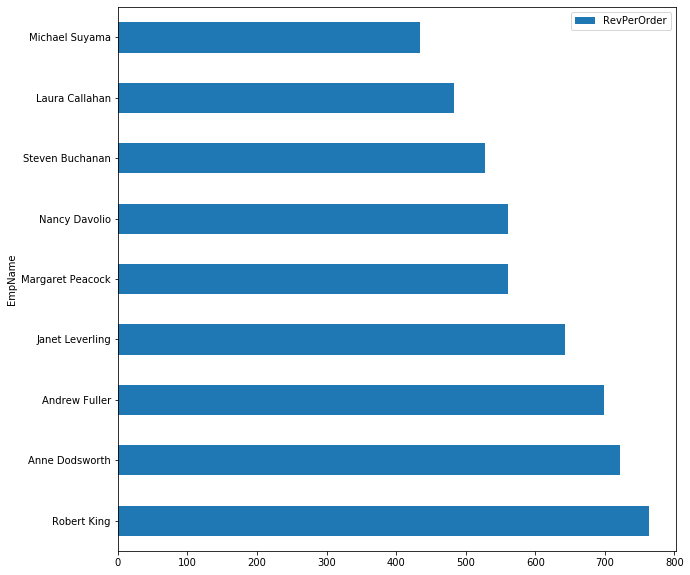

In [16]:
df_emp_performance = df_master.groupby('EmpName').agg({'TotalPaid':'sum','DiscAmount':'sum','ODRecords':'count'})

df_emp_performance['RevPerOrder'] = df_emp_performance['TotalPaid'] /df_emp_performance['ODRecords']
df_emp_performance.sort_values(by='RevPerOrder',ascending=False,inplace=True)

df_emp_performance.plot(y='RevPerOrder',kind='barh',figsize=(10,10))
display(df_emp_performance)
fig = plt.gcf()
fig.savefig("EmpOrderPErRev")

## Significance testing

We can see that some employees seem to generate higher revenue per order than others. Robert King seems to be doing better than everyone!  To make this determination, we will compare the Total Paid for each order for Robert King against the total paid for all other employees, and see if the difference is significant. 


In [17]:
pd.set_option('display.float_format', lambda x:'%.6f' % x)

highest_emp = df_master[df_master['EmpName'] == 'Robert King']['TotalPaid']
remain_emps = df_master.drop(highest_emp.index)['TotalPaid']

emp_hyp = hyp_test_mean(remain_emps,highest_emp)

,p_value,notes,Null Rejected
Difference in means,0.000000,186.405781,True
Cohen's d,0.000000,0.191265,True
Sample A normality,0.000000,0,True
Samp B normality,0.000000,0,True
Variance similarity,0.032848,0,True
t_test,0.024128,not used: assumptions not met,True
Welch's t-test,0.081602,1 !!Best Test!!,False
Mann Whitney U,0.116643,not needed: Welch's assumptions met,False


Hmmm. The Welch's t-test leads us to believe that we cannot prove our hypothesis that Robert King's higher sales performance is due to anything other than random chance. We see from our results table that a Welch's t-test is the preferred test. This is probably because the probability of the variances being equal is around 3.3%. 

However, it is interesting to note that under a regular t-test, our null hypothesis is rejected and Rober King's performance would seem to be significantly better than those of his peers. Given that a 3.3% chance of the variances being similar is not too far below our threshold of 5%, perhaps there may be some correlation after all. 

Lets run a Monte Carlo and see what hapens. 

In [18]:
bob_monte = monte_carlo(remain_emps,highest_emp,10000)
print(bob_monte)

In 10000 samples, The difference in mean between the experimental group and control group was higher than the observed values 2.5 % percent of the time
0.025


Very interesting! Our Monte Carlo simulation seems to yield results virtually identical to what we saw with a standard t-test. The odds of seeing an average Total Paid per purchase that is as much or higher than what we observed for Robert King is 2.5%. 

As such, at this stage I am inclined to conclude that at least Robert King's higher average revenue per order is statistically significant and not merely due to random chance.

## Confounding variables


However, even if random chance cannot account for the the higher revenues per order, there could be other explanations. 

For example, what if some employees generate more revenue because they sell to regions where customers spend more? Ofcourse, that could itself be a strategic decision on the employees part: they purposefully focus on higher spending regions. It could also be the case that employees are assigned regions, in which case we can hardly credit employees for generating higher revenue when they just got lucky and were assigned to a higher paid territory. 

It seems then that we must look at rates at which different employees sell to different regions, and whether these rates are essentially similar across employees or if some employees can be said to sell more in some regions than others (and whether these higher sales in particular regions could have been simply the result of random chance). 


EmpName,Andrew Fuller,Anne Dodsworth,Janet Leverling,Laura Callahan,Margaret Peacock,Michael Suyama,Nancy Davolio,Robert King,Steven Buchanan
CustRegion,,,,,,,,,
British Isles,19.000000,19.000000,31.000000,20.000000,30.000000,21.000000,25.000000,18.000000,7.000000
Central America,11.000000,1.000000,7.000000,4.000000,9.000000,1.000000,14.000000,6.000000,4.000000
Eastern Europe,1.000000,1.000000,1.000000,4.000000,2.000000,3.000000,5.000000,1.000000,2.000000
North America,37.000000,13.000000,67.000000,49.000000,77.000000,44.000000,97.000000,24.000000,19.000000
Northern Europe,16.000000,6.000000,26.000000,25.000000,17.000000,6.000000,26.000000,14.000000,7.000000
Scandinavia,19.000000,3.000000,8.000000,9.000000,7.000000,2.000000,12.000000,6.000000,4.000000
South America,32.000000,10.000000,47.000000,44.000000,71.000000,18.000000,43.000000,19.000000,20.000000
Southern Europe,22.000000,4.000000,12.000000,15.000000,38.000000,1.000000,20.000000,12.000000,13.000000
Western Europe,81.000000,52.000000,115.000000,78.000000,157.000000,66.000000,99.000000,51.000000,37.000000


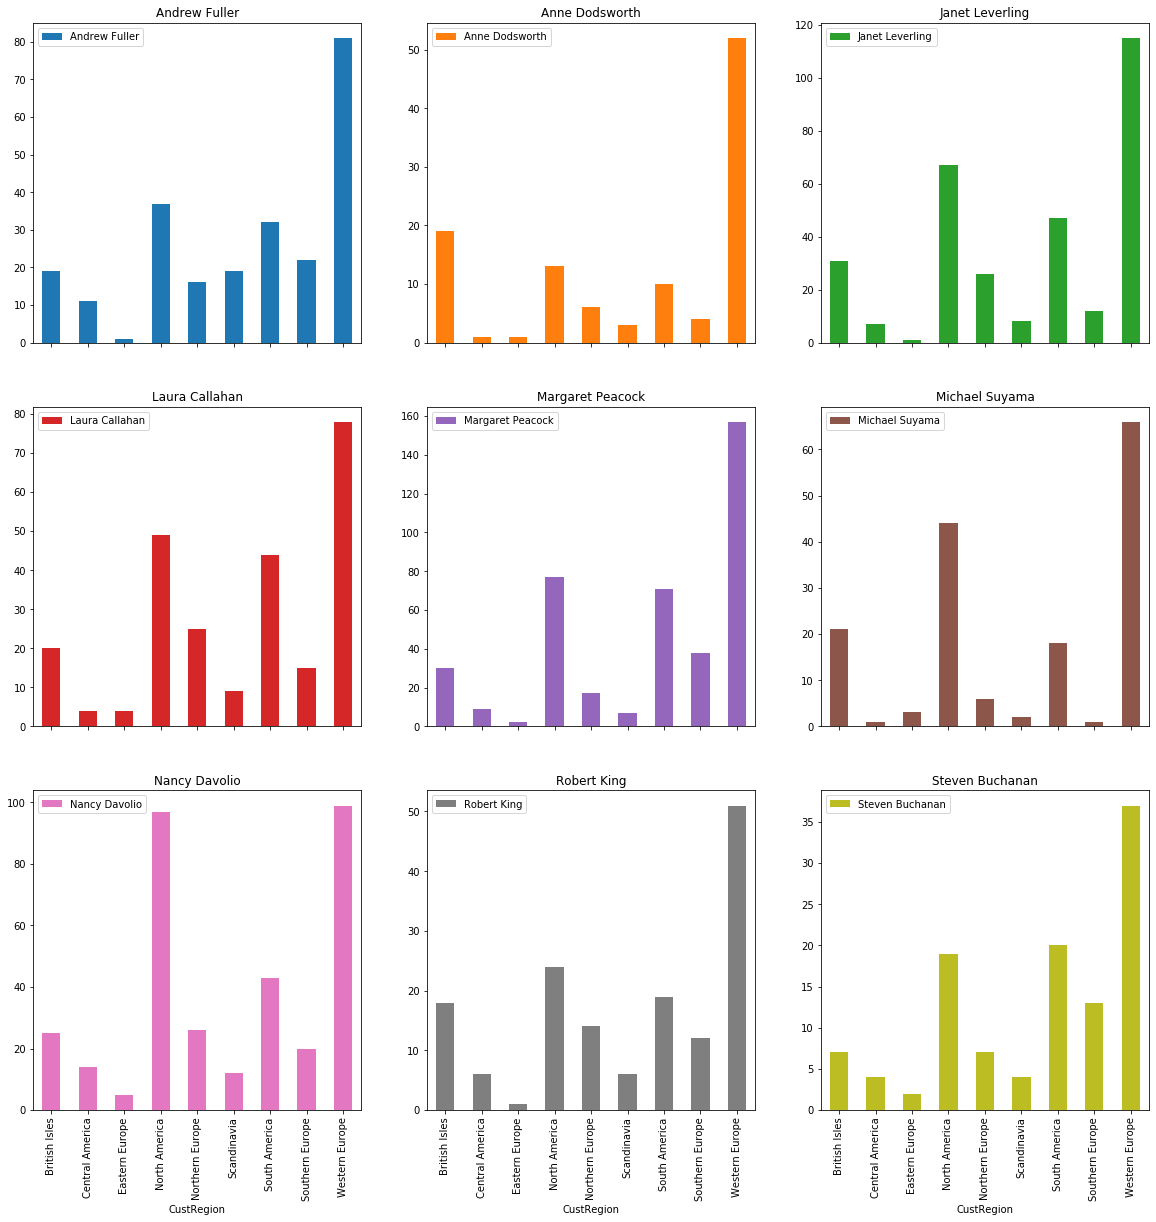

In [19]:
df_empterr = df_master[['EmpName','CustRegion','ODRecords']] #.pivot(index='CustRegion',columns='EmpName')
df_empterr = df_empterr.pivot_table(index='CustRegion',columns='EmpName',aggfunc='count').fillna(1)
df_empterr.columns = df_empterr.columns.droplevel() 

display(df_empterr)
df_empterr.plot(subplots=True,kind='bar',layout=(3,3),figsize=(20,20))
fig = plt.gcf()
fig.savefig("EmpSalesByRegion")

## Conclusion
We see from the above charts that employees seem to sell in different regions at almost exactly the same rates. This increases our confidence in our conclusion that Robert King truly is the King of Sales. 

# Fourth Hypothesis: Do customers prefer buying from the same region ?

Im curious to see if customers from particular regions have a tendency to prefer local products. 

<b>Null hypotheses:</b> The proportion of local products purchased by customers in a given region is not significantly different than the rate of local purchases for all the other customers from all other regions. 

<b> Alternative Hypothesis</b>: The customers in the given region are significantly more or less likely to purchase local products 

The code below will add up the number of local purchases made by customers in each region and compare that number to their total purchases. Then we will calculate similar proportions for all other customers and regions and compare the two proportions to see what the liklihood is of seeing the proportion of local purchases observed in this region given the expected average of local purchases we derived from the overall population. 

The resuling data frame will tell us whether we can reject our null hypothesis, and if so, whether the proportion of local purchases is significantly higher or lower, i.e. whether customers from that region prefer buying local or imported products. 

/home/khan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Population proportion of local products,Regions proportion of local purchases,Difference of Means,P-val of binomial test,Null Rejected,Exports or Imports?
Western Europe,0.108793,0.206522,-0.097729,0.000000,No,Local
Southern Europe,0.147347,0.087591,0.059755,0.052820,No,
South America,0.163472,0.026316,0.137157,0.000000,Yes,Imports
Scandinavia,0.144920,0.100000,0.044920,0.394031,No,
Northern Europe,0.147287,0.090909,0.056378,0.058709,No,
North America,0.125984,0.210773,-0.084789,0.000001,No,Local
Eastern Europe,0.144520,0.000000,0.144520,0.151585,No,
Central America,0.147306,0.000000,0.147306,0.000360,Yes,Imports
British Isles,0.149364,0.084211,0.065154,0.010543,Yes,Imports


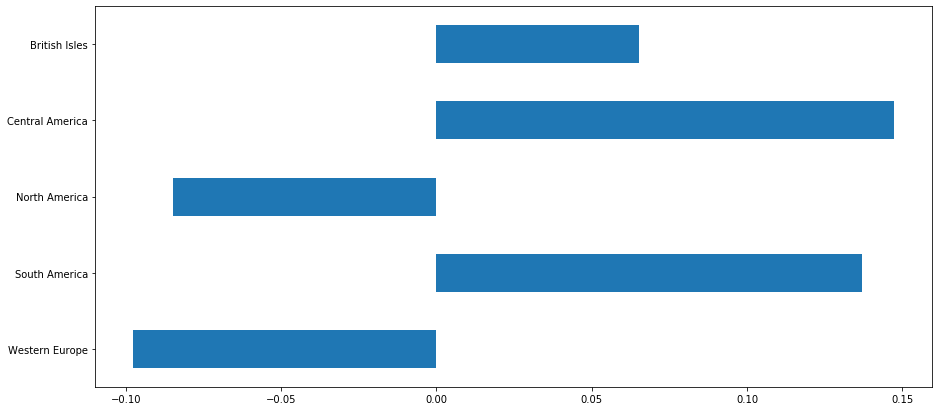

In [20]:
df_region_pref = df_master[['CustRegion','SuppRegion']]
df_region_pref["SameReg?"] =  df_region_pref['CustRegion'] == df_region_pref['SuppRegion']

regions_group = df_region_pref.groupby('CustRegion')
all_regions = list(regions_group.groups.keys())


final_df = {}

for region in all_regions:

    
    df_region = regions_group.get_group(region)
    region_same_p = df_region['SameReg?'].sum()
    seen_p = region_same_p/len(df_region)
    
    
    df_control = df_region_pref.drop(labels=list(df_region.index),axis=0)
    exp_p =  (df_control['SameReg?'].sum())/len(df_control)

    p = stats.binom_test(x=region_same_p,n=len(df_region),p=exp_p)
    
    result = "No"
    res_type=''
    if p < 0.05 and seen_p < exp_p:
        result = "Yes"
        res_type = "Imports"
    elif p < 0.05 and seen_p > exp_p:
        res_type = 'Local'
    mean_diff = exp_p - seen_p
    
    final_df[region] = [exp_p,seen_p,mean_diff,p,result,res_type]
    
columns=[
    'Population proportion of local products',
    'Regions proportion of local purchases',
    'Difference of Means',
    'P-val of binomial test',
    'Null Rejected',
    'Exports or Imports?'
]
    
results = pd.DataFrame.from_dict(final_df,orient='index',columns=columns).sort_index(ascending=False)

display(results)

results[results['Exports or Imports?'] != '']['Difference of Means'].plot(kind='barh',figsize=(15,7))


## Conclusion:
    
    We can see from our results that the British Isles, Central America and South America seem to prefer imported goods, while North America and Western Europe prefer local goods. This is kind of in line with what we would expect knowing that North America and Europe are generaly places from where luxury food items originate. Now we have statistical evidence on which markets prefer imported vs local products and can modify sales strategy accordingly. 